In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics


from pysolar.solar import *
import datetime

/tmp/ipykernel_279506/2101664275.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-25 14:43:08.130171: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 14:43:08.164287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 14:4

In [2]:
import openeo
import rasterio.plot
import io
import tarfile

In [3]:
import xarray as xr
f='/cloud/openeo/time_series_2_tiny_forest'
loaded_data = xr.open_dataset(f, engine='netcdf4', decode_times=True)
nodata = loaded_data.attrs.get("nodata", None)
loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
loaded_data

<xarray.Dataset> Size: 6MB
Dimensions:      (t: 12, y: 68, x: 80)
Coordinates:
  * t            (t) datetime64[ns] 96B 2020-06-01T10:36:29.024000 ... 2020-0...
  * y            (y) float64 544B 6.801e+06 6.801e+06 ... 6.8e+06 6.8e+06
  * x            (x) float64 640B 4.545e+05 4.545e+05 ... 4.553e+05 4.553e+05
    spatial_ref  int32 4B 3006
Data variables:
    b02          (t, y, x) float64 522kB 948.0 888.0 ... 1.209e+03 1.21e+03
    b03          (t, y, x) float64 522kB 852.0 768.0 767.0 ... 981.0 986.0 982.0
    b04          (t, y, x) float64 522kB 652.0 603.0 588.0 ... 710.0 701.0 699.0
    b05          (t, y, x) float64 522kB 929.0 929.0 915.0 ... 901.0 901.0 901.0
    b06          (t, y, x) float64 522kB 1.553e+03 1.553e+03 ... 1.687e+03
    b07          (t, y, x) float64 522kB 1.797e+03 1.797e+03 ... 2.067e+03
    b08          (t, y, x) float64 522kB 1.922e+03 1.812e+03 ... 1.992e+03
    b8a          (t, y, x) float64 522kB 2.014e+03 2.014e+03 ... 2.23e+03
    b09          (t, y, x) float64 522kB 764.0 764.0 764.0 ... 587.0 587.0 587.0
    b10          (t, y, x) float64 522kB 15.0 15.0 15.0 15.0 ... 44.0 44.0 44.0
    b11          (t, y, x) float64 522kB 1.482e+03 1.482e+03 ... 1.106e+03
    b12          (t, y, x) float64 522kB 796.0 796.0 720.0 ... 550.0 544.0 544.0
Attributes:
    crs:                EPSG:3006
    nodata:             -9999
    collection:         s2_msi_l1c
    datetime_from_dim:  2024-03-25T13:33:26.513298

In [4]:
times=loaded_data['t']
variables=loaded_data.variables

In [68]:
times.data[0]

numpy.datetime64('2020-06-01T10:36:29.024000000')

In [92]:
## Bounding box coordinates ##
# OBS: need to change if image change #
west= 14.150380155088326
east= 14.164926751025039
south= 61.33075653979347
north= 61.33671336788572

lat=(west+east)/2
long=(south+north)/2

In [5]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

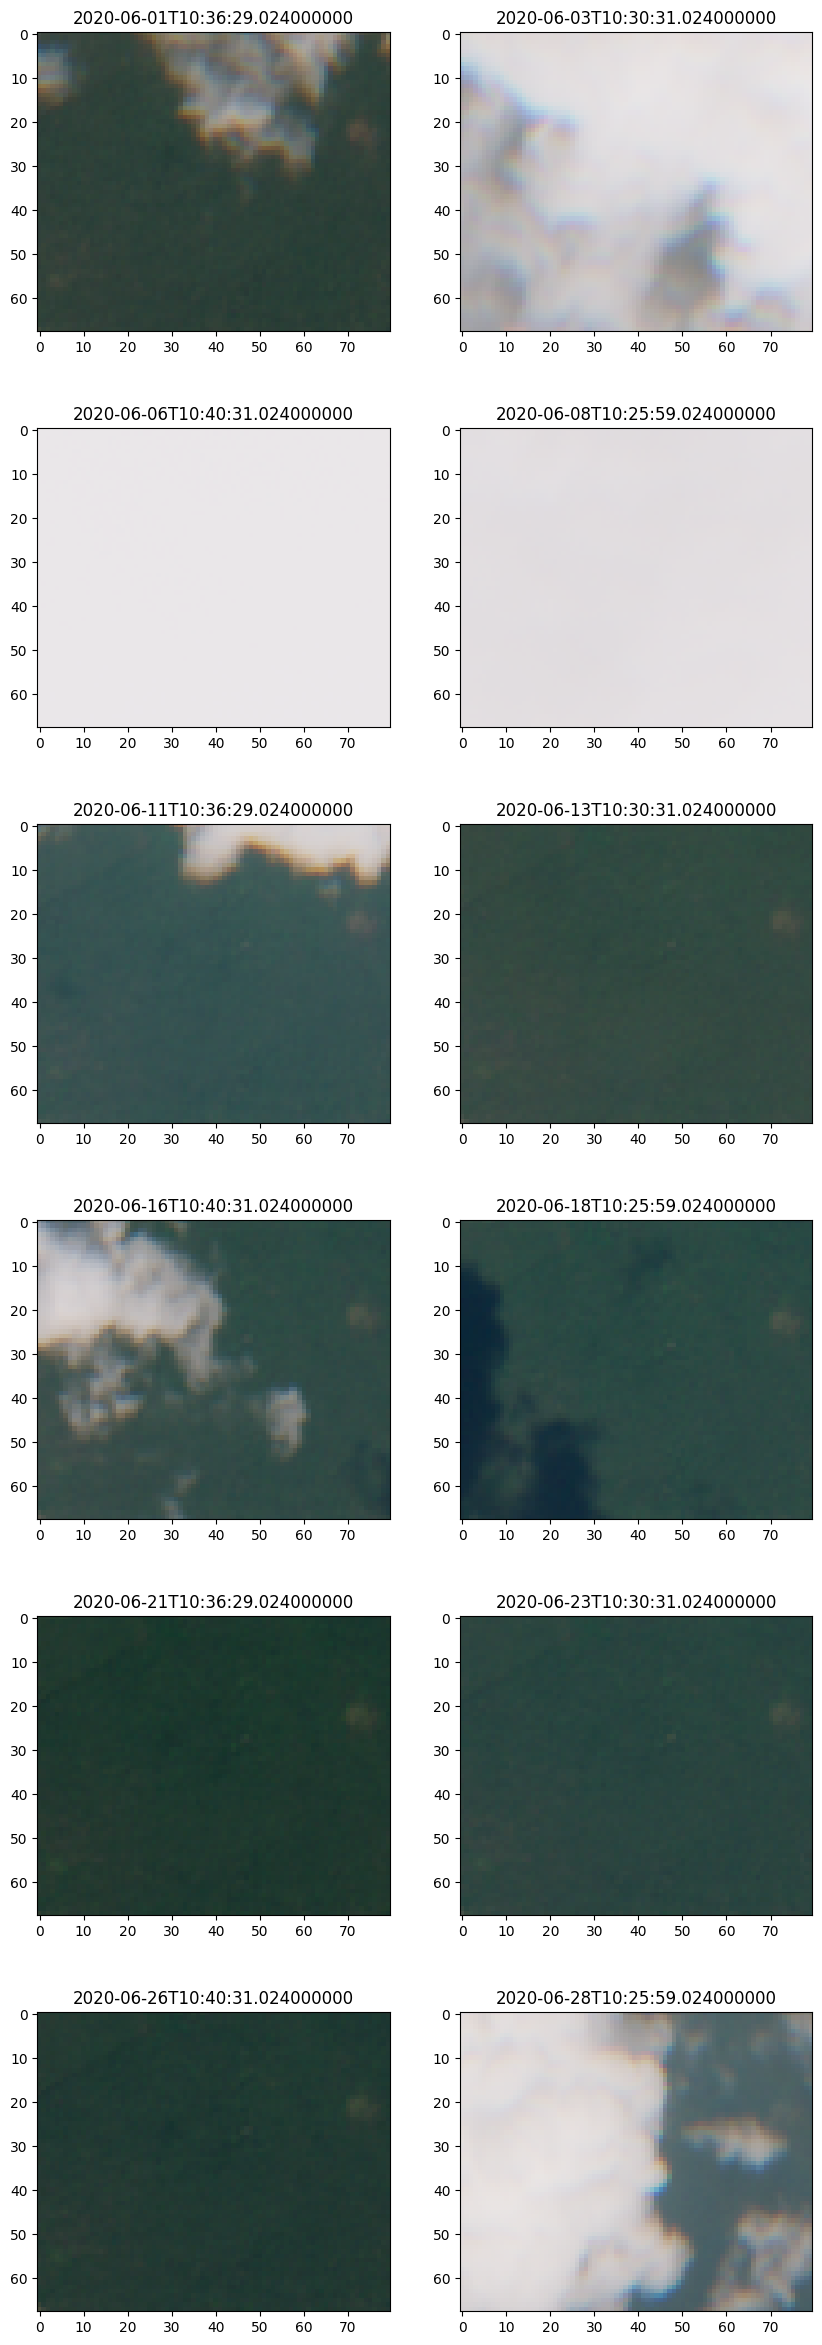

In [45]:
ncols=2
nrows=int(np.ceil(len(times)/ncols))
divide=10000
ims=[]
ims_show=[]
sun_zenith_angles=[]

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):

    ## Get bands ##
    b02=variables['b02'].data[i,:,:]/divide
    b03=variables['b03'].data[i,:,:]/divide
    b04=variables['b04'].data[i,:,:]/divide
    b05=variables['b05'].data[i,:,:]/divide
    b06=variables['b06'].data[i,:,:]/divide
    b07=variables['b07'].data[i,:,:]/divide
    b08=variables['b08'].data[i,:,:]/divide
    b8a=variables['b8a'].data[i,:,:]/divide
    b09=variables['b09'].data[i,:,:]/divide
    b10=variables['b10'].data[i,:,:]/divide
    b11=variables['b11'].data[i,:,:]/divide
    b12=variables['b12'].data[i,:,:]/divide

    ## Get Angles ##
    tmp=times.data[i].astype('datetime64[us]')
    tmp=tmp.astype(datetime.datetime)
    dobj = datetime.datetime(tmp.year,tmp.month,tmp.day,tmp.hour,tmp.minute,tmp.second,tmp.microsecond,tzinfo=datetime.timezone.utc)
    sea = get_altitude(lat, long, dobj)
    sza = float(90)- sea
    sun_zenith_angles.append(sza)

    ## Get "True" RGB ##
    b04T=sAdj(b04-ray['r'])
    b03T=sAdj(b03-ray['g'])
    b02T=sAdj(b02-ray['b'])

    rgbLin=satEnh(b04T,b03T,b02T)
    #avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
    for k,p in enumerate(rgbLin[0]):
        for j,q in enumerate(p):
            rgbLin[0][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[1]):
        for j,q in enumerate(p):
            rgbLin[1][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[2]):
        for j,q in enumerate(p):
            rgbLin[2][k,j]=sRGB(q)

    im_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
    im_show[:,:,0]=rgbLin[0]
    im_show[:,:,1]=rgbLin[1]
    im_show[:,:,2]=rgbLin[2]
    ims_show.append(im_show)

    ## Save image ##
    im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],12))
    im[:,:,0]=b02
    im[:,:,1]=b03
    im[:,:,2]=b04
    im[:,:,3]=b05
    im[:,:,4]=b06
    im[:,:,5]=b07
    im[:,:,6]=b08
    im[:,:,7]=b8a
    im[:,:,8]=b09
    im[:,:,9]=b10
    im[:,:,10]=b11
    im[:,:,11]=b12
    ims.append(im)

    ax.imshow(im_show)
    ax.set_title(times.data[i])
    

In [7]:
pair=[5,6]
im_clear=ims[pair[0]]
im_cloud=ims[pair[1]]

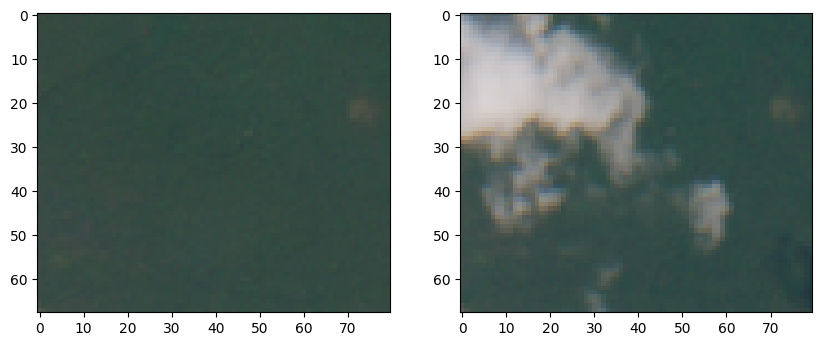

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])

In [9]:
## Load models
main_filepath='pytorch_models/many_quantiles'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [10]:
## Reshape cloudy data
im_shape=np.shape(im_cloud)
im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
for i in range(im_shape[2]):
    im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])


In [11]:

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r)
    else:   
        pred=pred+model.predict(im_cloud_r)
pred=pred/len(models)

In [28]:
##Reshape back
index_median=4
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


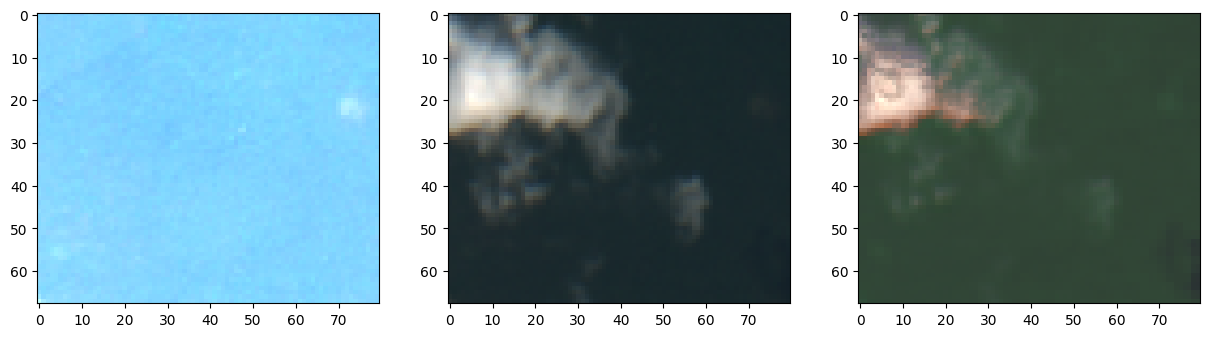

In [29]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(np.flip(im_clear[:,:,0:3],axis=2)/np.max(im_clear[:,:,0:3],axis=(0,1)))
axs[1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)/np.max(im_cloud[:,:,0:3],axis=(0,1)))
axs[2].imshow(np.flip(im_pred[:,:,0:3],axis=2)/np.max(im_pred[:,:,0:3],axis=(0,1)))

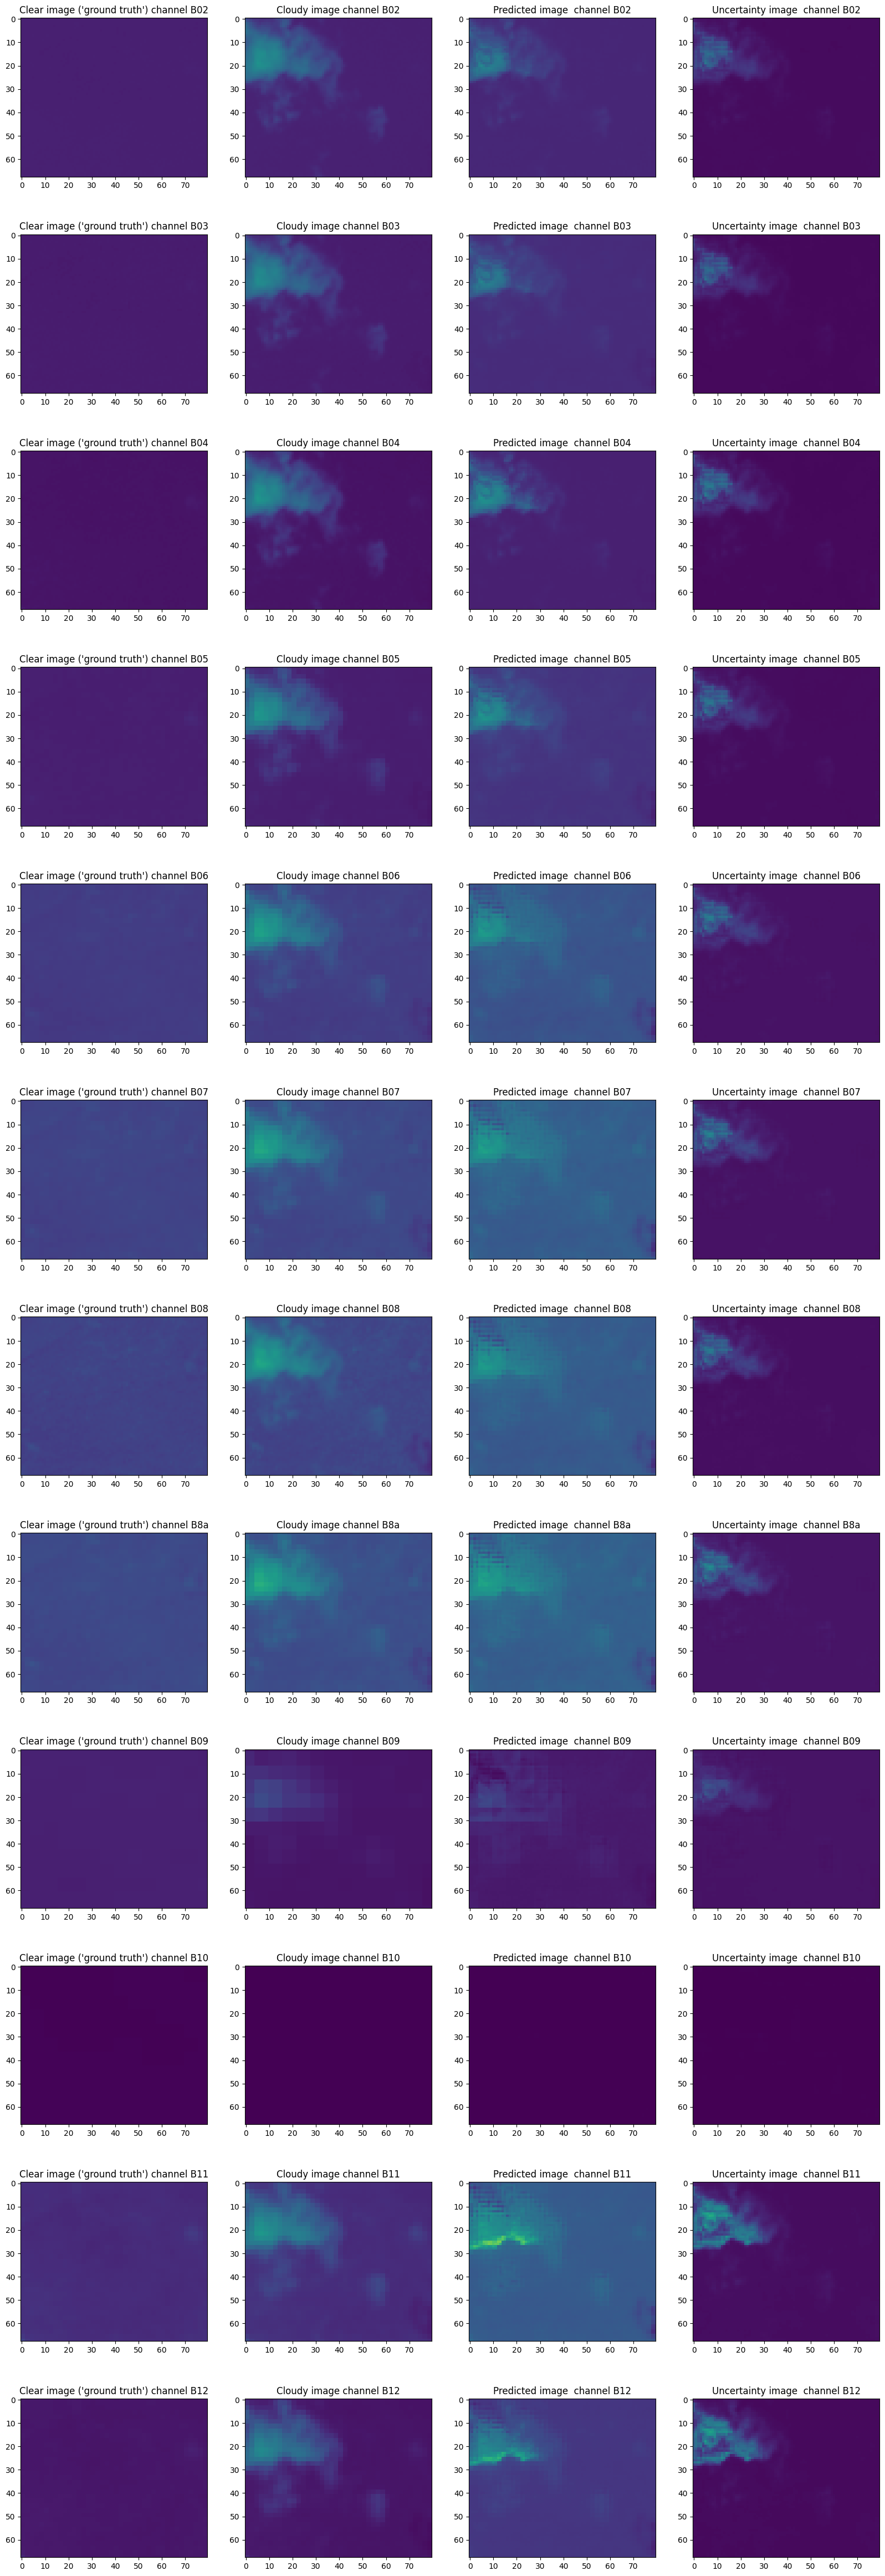

In [34]:
nchannels=12
plt.rcParams['figure.figsize'] = [20, 5*nchannels]
fig,axs=plt.subplots(ncols=4,nrows=nchannels)
for i in range(nchannels):
    axs[i,0].imshow(im_clear[:,:,i],vmin=0,vmax=1)
    axs[i,1].imshow(im_cloud[:,:,i],vmin=0,vmax=1)
    im_tmp=axs[i,2].imshow(im_pred[:,:,i],vmin=0,vmax=1)
    
    axs[i,3].imshow(im_unc[:,:,i],vmin=0,vmax=1)
    

    if i<7:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+2))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+2))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+2))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+2))
    elif i==7:
        axs[i,0].set_title("Clear image ('ground truth') channel B8a")
        axs[i,1].set_title("Cloudy image channel B8a")
        axs[i,2].set_title("Predicted image  channel B8a")
        axs[i,3].set_title("Uncertainty image  channel B8a")
    elif i==8:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+1))
    else:
        axs[i,0].set_title("Clear image ('ground truth') channel B"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B"+str(i+1))

In [31]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud)),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

In [35]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before corrrection, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after corrrection, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before corrrection, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after corrrection, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before corrrection, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after corrrection, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

NMSE before corrrection, Band 2: 11.412219542882733
NMSE after corrrection, Band 2: 3.5614067553583637
 
NMSE before corrrection, Band 3: 17.801785968456542
NMSE after corrrection, Band 3: 6.561443413682958
 
NMSE before corrrection, Band 4: 142.19100715783964
NMSE after corrrection, Band 4: 90.33926666033246
 
NMSE before corrrection, Band 5: 15.740048113145177
NMSE after corrrection, Band 5: 11.249526005121119
 
NMSE before corrrection, Band 6: 0.5595092067657154
NMSE after corrrection, Band 6: 0.4513141516824297
 
NMSE before corrrection, Band 7: 0.32207689811849893
NMSE after corrrection, Band 7: 0.29358940247607807
 
NMSE before corrrection, Band 8: 0.304060826352109
NMSE after corrrection, Band 8: 0.2649500685094298
 
NMSE before corrrection, Band 8A: 0.2359121048746423
NMSE after corrrection, Band 8A: 0.21720135619055583
 
NMSE before corrrection, Band 9: 0.09866698829400795
NMSE after corrrection, Band 9: 0.03688994384935195
 
NMSE before corrrection, Band 10: 0.517562288220986